![alt text](images/HDAT9500Banner.PNG)
<br>

# Chapter 4: Tree Based Methods
# Exercise 01: Decision Trees and Gradient Boosting Trees


# 1. Introduction

In this exercise, we will introduce tree based methods. First, we will learn about the basic decision tree, then we will see how decision tree performance can be improved via ensemble methods - specifically, gradient descent boosting.


## 1.1. Aims of the Exercise:
 1. To introduce the single Decision Tree, as well as the Gradient Boosted Trees.
 2. To explore parameters and determine appropriate choices.

 
It aligns with all of the learning outcomes of our course: 

1.	Distinguish a range of task specific machine learning techniques appropriate for Health Data Science.
2.	Design machine learning tasks for Health Data Science scenarios.
3.	Construct appropriate training and test sets for health research data.


## 1.2. Jupyter Notebook Intructions
1. Read the content of each cell.
2. Where necessary, follow the instructions that are written in each cell.
3. Run/Execute all the cells that contain Python code sequentially (one at a time), using the "Run" button.
4. For those cells in which you are asked to write some code, please write the Python code first and then execute/run the cell.
 
## 1.3. Tips
 1. The square brackets on the left hand side of each cell indicate whether the cell has been executed or not. Empty square brackets mean that the cell has not been executed, whereas square brackets that contain a number means that the cell has been executed. Run all the cells in sequence, using the "Run" button.
 2. To edit this notebook, just double-click in each cell. In the document, each cell can be a "Code" cell or "text-Markdown" cell. To choose between these two options, go to the combo-box above. 
 3. If you want to save your notebook, please make sure you press the "floppy disk" icon button above. 
 4. To clean the content of all cells and re-start the Notebook, please go to Cell->All Output->Clear


# 2. Load the Wisconsin Cancer Data Set

For data dictionary and all information:
https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

In [2]:
import sys
print(sys.version)

import numpy as np
import pandas as pd
from IPython.display import display

from plotnine import *

3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]


In [3]:
cancer = pd.read_csv('data/breast-cancer-wisconsin-data/data.csv', sep=',')

In [4]:
# Sanity Check:
display(cancer[:][:5])
print(cancer.shape)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


(569, 32)


In [5]:
cancer.dtypes

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

## 2.1.Split the data into features and response

In [6]:
X = cancer.drop(axis=1, columns=['id', 'diagnosis'])
y = cancer[['diagnosis']].values

In [7]:
# Sanity check
# display(X[:][:5])
# display(y[:][:5])

## 2.2. Split the data into training and test sets

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0, test_size = 0.20)

# 3. Decision Trees
Decision Trees involve segmenting the feature space (the space of our predictor variables) into a number of different regions. The method can be used for both regression (predicting numeric response variable) and classification (classifying a categorical response variable). As the set of splitting rules used to segment the feature space can be summarized into a hierarchy of if/else statements in the form of a tree, these types of approaches are known as decision tree methods.<p>
    In the case of **regression**, in order to make a prediction for any particular observation, we usually use the mean of the training observations in the region to which it belongs. For **classification**, we usually use the mode of the training observations in the region to which the data point belongs. Recall that the mode is the most frequent element. So, *for classification we predict that each observation belongs to the most commonly occurring class of training observations in the region to which it belongs*.<p>
        We will use tree methods to predict cancer diagnosis, which is a classification task.

## 3.1. Growing a simple decision tree
Beginning with what is known as the *root node*, the node containing the entire dataset, we split the data based on the feature that provides the most information about the response variable. The split is achieved by using a *test*. The form of the test depends on the data type of the chosen feature.
* If the feature of choice is continuous, the test will be of the form $X_i > a$, where $a$ is some constant. In other words, the tests that are used on continuous data are of the form 'is feature i larger than the value a?'. 
* If the feature is categorical, the test will be $X_i = c$, where $c$ is one of the levels of the categorical variable. In other words, the tests that are used on categorical data are of the form 'is feature i of the same level as c?'. <p>
    
After assessing the test, the result will be two *children nodes*, one node being for all the data that satisfy the root node test and one node for all data points that do not satisfy the root node test.<p>
    We then continue this process of finding informative rules and splitting the data. Resulting in a tree of nodes. The nodes in which we assign a value to the given observations are known as *leaf nodes*. 

## 3.2. Avoiding overfitting - pruning the tree
If we allow the process of testing and splitting to continue indefinitely, we will have a tree with every leaf node being *pure*. *Pure* means that there are only data points of a single class label in the final leaf node. More often than not, such a tree will be very complex and highly overfitted to the training data. There are two common methods to prevent overfitting:
1. **Pre-pruning**: Preventing overfitting before the creation of the tree. Common criteria for pre-pruning includes limiting the maximum depth of the tree, limiting the maximum number of leaves, or placing a minimum size constraint on the nodes that must be satisfied for a split to occur.
2. **Post-pruning**: Removing overfitted leaf nodes after the creation of the tree. This is commonly referred to as "pruning". <p>
    
Decision trees in scikit-learn are implemented in the **DecisionTreeRegressor** and **DecisionTreeClassifier** classes. **scikit-learn** only implements pre-pruning, not post-pruning.

## 3.3. Create a decision tree with no pruning

We will create a decision tree with no pruning. We will see that some of the nodes will have only 1 sample. 

In [9]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [10]:
simple_decision_tree = DecisionTreeClassifier(random_state=0)
simple_decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [11]:
print("Accuracy on training set: {:.3f}".format(simple_decision_tree.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(simple_decision_tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.930


### 3.3.1 Confusion Matrix

![alt text](images/Confusion_matrix.PNG)

[[41  1]
 [ 7 65]]


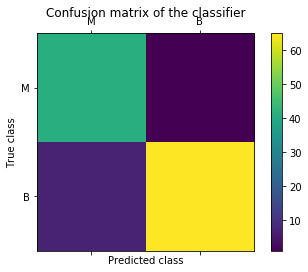

In [12]:
from sklearn.metrics import confusion_matrix
cancer_labels = ['M', 'B']
y_pred = simple_decision_tree.predict(X_test)
cm = confusion_matrix(y_true = y_test, y_pred = y_pred, labels=cancer_labels)
print(cm)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + cancer_labels)
ax.set_yticklabels([''] + cancer_labels)
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          B       0.98      0.90      0.94        72
          M       0.85      0.98      0.91        42

avg / total       0.94      0.93      0.93       114



### 3.3.2 Visualization

The next lines of code might not work if you don't have graphviz installed in your computer:

For Windows:

1. Install windows package from: https://graphviz.gitlab.io/_pages/Download/Download_windows.html
2. Install python graphviz package 
    !pip install graphviz 
    or
    !conda install graphviz
3. Add C:\Program Files (x86)\Graphviz2.38\bin to User path
4. Add C:\Program Files (x86)\Graphviz2.38\bin\dot.exe to System Path

For Mac:

1. MacPorts* provides both stable and development versions of Graphviz and the Mac GUI Graphviz.app. These can be obtained via the ports “graphviz”, “graphviz-devel”, “graphviz-gui” and “graphviz-gui-devel”: https://www.macports.org/
2. Homebrew* has a Graphviz port: https://brew.sh/


In [14]:
from sklearn.tree import export_graphviz
export_graphviz(simple_decision_tree, out_file="tree.dot", class_names=["malignant", "benign"], feature_names=X.columns, impurity=False, filled=True)


import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

ModuleNotFoundError: No module named 'graphviz'

## 3.4. Pre-pruning a tree
As mentioned previously, scikit-learn only implements pre-pruning, not post-pruning, so we will only demonstrate how pre-pruning works.<p>
    Now let’s apply pre-pruning to the tree, which will stop growing the tree before we perfectly fit it to the training data. 

<div class="alert alert-block alert-success">**Start Activity**</div>

### <font color='blue'> Question 1: Set the maximum depth equal to 3, meaning only 3 consecutive splits can be made </font>

In [ ]:
# Write Python Code here
decision_tree_max_depth3 = DecisionTreeClassifier(random_state=0, max_depth = 3)
decision_tree_max_depth3.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(decision_tree_max_depth3.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(decision_tree_max_depth3.score(X_test, y_test)))

<div class="alert alert-block alert-warning">**End Activity**</div>

### 3.4.1. Confusion Matrix

![alt text](images/Confusion_matrix.PNG)

In [ ]:
from sklearn.metrics import confusion_matrix
cancer_labels = ['M', 'B']
y_pred_max_depth3 = decision_tree_max_depth3.predict(X_test)
cm_max_depth3 = confusion_matrix(y_true = y_test, y_pred = y_pred_max_depth3, labels=cancer_labels)
print(cm_max_depth3)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + cancer_labels)
ax.set_yticklabels([''] + cancer_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_max_depth3))

### 3.4.2 Visualisation

In [ ]:
from sklearn.tree import export_graphviz
export_graphviz(decision_tree_max_depth3, out_file="tree.dot", class_names=["malignant", "benign"], feature_names=X.columns, impurity=False, filled=True)


import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

The visualization of the tree allows for an intuitive interpretation on how the algorithm classifies its data.<p>

<div class="alert alert-block alert-success">**Start Activity 4**</div>

### <font color='blue'> Question 2: Did we improve our accuracy / precision-recall? Why? </font>

<b> Write your answer here:</b>
#####################################################################################################################

We did improve our accuracy, precision and recall.
Why? Because by restricting the depth of the 3, we avoid overfitting. That is, the model doesn't overfit to the training set. It generalizes better. 


#####################################################################################################################

<div class="alert alert-block alert-warning">**End Activity 4**</div>

### 3.4.2. Feature importance
There are some useful properties that we can derive to summarise the workings of the tree. A common example is *feature importance*, which as its name suggests, numerically rates the importance each feature plays in the decision making process of the tree. It is a number between 0 and 1, with the sum of all feature importances equalling to 1.

In [ ]:
print("Feature importances:\n{}".format(decision_tree_max_depth3.feature_importances_))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

In [ ]:
plot_feature_importances(decision_tree_max_depth3)

This is not an effective visualization, as we have so many features. The solution is to remove all features that are of very low importance. We will only select the features whose feature importance is greater than 0.01.

In [ ]:
def plot_feature_importances(model):
    
    #locate indices of the features with feature importance greater than 0.01
    indices = np.where(model.feature_importances_ > 0.01)[0]
    
    #extract the number of features that have non-zero feature importance
    n_features = X.iloc[:,indices].shape[1]
    
    #plot the features that have a non-zero feature importance
    plt.barh(range(n_features), model.feature_importances_[indices], align='center') 
    plt.yticks(np.arange(n_features), X.iloc[:,indices].columns) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

In [ ]:
plot_feature_importances(decision_tree_max_depth3)

From the IMLP textbook: **"... if a feature has a low feature_importance, it doesn’t mean that this feature is uninformative. It only means that the feature was not picked by the tree, likely because another feature encodes the same information."**

## 3.5. Advantages/disadvantages of decision trees
**Advantages**:
* Easy interpretation and visualization of decision rules. Particularly to non-experts.
* Very fast to train, and then predict.
* Invariant to scaling of the data. This removes the need for preprocessing such as the standardisation that was needed for the regularized logistic models.
* Are able to predict non-linear data.
* Can be used to determine feature importance.
* Further, provides automatic feature selection by only choosing the important features by which the data are split. This further reduces the need for preprocessing.
* Provides probability estimates. <p>

**Disadvantages**:
* Tendency to overfit, even after pruning methods.
* Often outperformed by other models, including the ensemble methods utilising the basic decision tree, which we will discuss now.

# 4. Gradient Boosted Decision Trees
Gradient Boosted Descision Trees are an *ensemble* of decision trees. *Ensemble* is a general term referring to methods that combine multiple machine learning models to create a more powerful model. There are two widely used ensembles based on decision trees: *Gradient Boosted Decision Trees*, and *Random Forests*. Here, we will introduce Gradient Boosted Decision Trees, and deal with Random Forests during this chapter's assessment.<p>

Gradient boosting works by building a large number of trees where each tree tries to correct the mistakes of the previous one. The way this is achieved is by fitting each subsequent tree on a modified version of the original dataset, depending on how the previous trees performed. Given the current model, we fit a decision tree to the residuals (the unexplained variation) from the model. That is, we fit a new tree using the current residuals, rather than the whole response Y, as the response. We then add this new decision tree into the fitted function in order to update the residuals.<p> 

Readings and videos:
1. Scikit-learn API: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
2. Video 1: Regression https://www.youtube.com/watch?v=3CC4N4z3GJc
3. Video 2: Classification https://www.youtube.com/watch?v=jxuNLH5dXCs

In [ ]:
y_train_binary = [0 if x =='M' else 1 for x in y_train]

# Sanity Check
print('Cancer (original y_train): ', y_train[35:45].reshape(1,-1))
print('y_train after binary conversion: ', y_train_binary[35:45])

In [ ]:
y_test_binary = [0 if x =='M' else 1 for x in y_test]

# Sanity Check
print('Cancer (original y_train): ', y_test[35:45].reshape(1,-1))
print('y_train after binary conversion: ', y_test_binary[35:45])

We are going to create the 'gbt' object *that encapsulates the algorithm that will be used to build the model from
the training data, as well the algorithm to make predictions on new data points. It will
also hold the information that the algorithm has extracted from the training data* (source: Book 1, Chapter 1). 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbt = GradientBoostingClassifier(random_state=0)

*To build the model on the training set, we call the fit method of the knn object* (source: Book 1, Chapter 1)

In [ ]:
gbt.fit(X_train, y_train_binary)

*The fit method returns the knn object itself (and modifies it in place), so we get a
string representation of our classifier. The representation shows us which parameters
were used in creating the model. Nearly all of them are the default values, but you can
also find* random_state=0, *which is the* hyper-parameter *that we passed. Most models in
scikit-learn have many parameters, but the majority of them are either speed optimizations
or for very special use cases.* (source: Book1, Chapter 1).

Let's calculate accuracy for the training and test set:

In [ ]:
print("Accuracy on training set: {:.3f}".format(gbt.score(X_train, y_train_binary)))
print("Accuracy on test set: {:.3f}".format(gbt.score(X_test, y_test_binary)))

In [ ]:
y_pred_gbt = gbt.predict(X_test)

from sklearn.metrics import confusion_matrix

print('Confusion matrix:')
print('')
cm_gbt = confusion_matrix(y_true = y_test_binary, y_pred = y_pred_gbt)
print(cm_gbt)


Interpretation of the confusion matrix:

![alt text](images/Confusion_matrix.PNG)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_max_depth3))

## 4.1. Parameters
In terms of parameters, we have the previous ones such as **depth of the tree**, **maximum number of leaves**, and **minimum splitting size**. However,  there is **no parameter for 'class_weight'** in gradient boosting trees for sklearn.  <p> 
    We also have two new parameters:
* n_estimators, the number of trees in the ensemble. Increasing n_estimators in gradient boosting leads to a more complex model, which may lead to overfitting
* Learning_rate. The learning rate controls how strongly each tree tries to correct the mistakes of the previous trees. Learning_rate is a decimal number between 0 and 1, with low values indicating slow learning and higher values indicating fast learning.

Ideally, we would like to tune the three most important parameters: n_estimator, max_depth, and learning_rate. However, as we are restrained by both time and computational power, we will restrict ourselves to tuning only the learning_rate. For max_depth, it is standard practice to limit the ensemble to quite shallow trees, so we we will choose max_depth = 3. The parameters n_estimator and learning_rate are highly interconnected, as a lower learning_rate means that more trees are needed to build a model of similar complexity. Using this knowledge, we will choose a value of n_estimators that is feasible given our time and computational power constraints, and then find the best learning_rate given this value of n_estimators.



## 4.2. Grid search
Here, we will attempt to find the parameters that maximise the f1 score, macro averaged. Remember, when using cross-validation and grid search it is good practice to reserve the test set until **after** we finish selecting parameters. 

In [ ]:
gbt_gridsearch = GradientBoostingClassifier(random_state=0)

### 4.2.1. First search

In [ ]:
param_grid = {'n_estimators': [15, 25, 50, 100],
              'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]}

Now initialise the GridSearchCV class by passing it the gradient boosted tree we have created, *gbt*, our paramater grid, *param_grid*, and specifying how many folds we would like. We must consider the computational complexity of the algorithm, so we can't set cv too high. We choose 5 folds. We also specify scoring = 'f1' to designate that we would like to use the F1 measure with an unweighted average of the classes.

In [ ]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(gbt_gridsearch, param_grid=param_grid, cv=5, scoring = 'f1')

We fit the grid search. *Fitting the GridSearchCV object not only searches for the best parameters, but also
automatically fits a new model on the whole training dataset with the parameters that
yielded the best cross-validation performance* (source: Book 1, Chapter 5). 

In [ ]:
grid_search.fit(X_train, y_train_binary)

*The important thing here is that we did not use the test set to choose the parameters. The parameters that were found are scored in the best_params_ attribute, and the best cross-validation accuracy (the mean accuracy
over the different splits for this parameter setting) is stored in best_score_:* (source: Book 1, Chapter 5)

In [ ]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation average f1 score: {:.2f}".format(grid_search.best_score_))

*Again, be careful not to confuse best_score_ with the generalization
performance of the model as computed by the score method
on the test set. Using the score method (or evaluating the output of
the predict method) employs a model trained on the whole training
set. The best_score_ attribute stores the mean cross-validation
accuracy, with cross-validation performed on the training set.* (source: Book 1, Chapter 5)

The procedure ".score()" will display F1 score of the positive class as we changed the "scoring='f1'" in the GridSearchCV function.

In [ ]:
print("Test set F1: {:.2f}".format(grid_search.score(X_test, y_test_binary)))

In this case, in order to print accuracy,

In [ ]:
# Let's predict in the training set, in order to calculate accuracy in the train set too, to see if our model is overfitted.
y_pred_grid_search_training_set= grid_search.predict(X_train)

# We predict in the test set
y_pred_grid_search = grid_search.predict(X_test)


from sklearn.metrics import accuracy_score
print("Accuracy on training set: {:.2f}".format(accuracy_score(y_train_binary, y_pred_grid_search_training_set)))
print("Accuracy on test set: {:.2f}".format(accuracy_score(y_test_binary, y_pred_grid_search)))

In [ ]:
cm_grid_search = confusion_matrix(y_true = y_test_binary, y_pred = y_pred_grid_search)
print(cm_grid_search)

Interpretation of the confusion matrix:

![alt text](images/Confusion_matrix.PNG)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_binary, y_pred_grid_search))

### 4.2.2. Second search

<div class="alert alert-block alert-success">**Start Activity**</div>

### <font color='blue'> Question 3: Define a second search with different values close to the optimal learning rate value found  in the previous section</font>

The optimal value was 0.2. Thus, we define values in the vecinity of 0.2, just to test if we can find some learning rate that performs better. We set the number of estimators to 50, as it is the best value found before.

In [ ]:
# Write Python Code Here:
param_grid_in_detail = {'n_estimators': [50],
              'learning_rate':  [0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24]}

### <font color='blue'> Question 4: Define the variable grid_search in which we will do "GridSearchCV" with CV=5 and for the f1 score </font>

In [ ]:
# Write Python Code Here:
grid_search_in_detail = GridSearchCV(gbt, param_grid=param_grid_in_detail, cv=5, scoring = 'f1')

### <font color='blue'> Question 5: "Fit" the models </font>

In [ ]:
# Write Python Code Here:
grid_search_in_detail.fit(X_train, y_train_binary)

### <font color='blue'> Question 6: Print the best parameters </font>

In [ ]:
# Write Python Code Here:
print("Best parameters: {}".format(grid_search_in_detail.best_params_))
print("Best cross-validation f1 score: {:.2f}".format(grid_search_in_detail.best_score_))

<div class="alert alert-block alert-warning">**End Activity**</div>

## 4.3. Fit and evaluate the gradient boosted tree with our optimal parameters

<div class="alert alert-block alert-success">**Start Activity**</div>

### <font color='blue'> Question 7: Train the new classifier with the best parameters found above </font>

<font color=green>**There is no need to train a new model**</font>

From Book 1, Chapter 5 [27]

grid_search.fit(X_train, y_train)

Fitting the GridSearchCV object not only searches for the best parameters, but also
automatically fits a new model on the whole training dataset with the parameters that
yielded the best cross-validation performance. What happens in fit is therefore
equivalent to the result of the In[21] code we saw at the beginning of this section. The
GridSearchCV class provides a very convenient interface to access the retrained
model using the predict and score methods. To evaluate how well the best found
parameters generalize, we can call score on the test set as follows:

Bear in mind, that "score" will display F1 (and not accuracy) because we changed it in the GridSearchCV

In [ ]:
# Write Python Code Here:
print("Test set F1: {:.2f}".format(grid_search_in_detail.score(X_test, y_test_binary)))

### <font color='blue'> Question 8: Compute the confusion matrix </font>

In [ ]:
y_pred_grid_search_in_detail = grid_search.predict(X_test)

In [ ]:
# Write Python Code Here:
cm_after_grid_search_in_detail = confusion_matrix(y_true = y_test_binary, y_pred = y_pred_grid_search_in_detail)
print(cm_after_grid_search_in_detail)

Interpretation of the confusion matrix:

![alt text](images/Confusion_matrix.PNG)

As you can see, the model didn't improve at all after trying to tune several hyper-parameters.
Feel free to try new hyper-parameters.

<div class="alert alert-block alert-warning">**End Activity**</div>

## 4.5. Visualising the gradient boosted tree: feature importance

Remember: 

You can access the model with the
best parameters trained on the whole training set using the best_estimator_.

We know that the best model found by GridSearchCV, **trained on all the training data**, is stored in grid.best_estimator_:

print("Best estimator:\n{}".format(grid.best_estimator_))

In [ ]:
print("Feature importances:\n{}".format(grid_search_in_detail.best_estimator_.feature_importances_))

In [ ]:
def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

In [ ]:
plot_feature_importances(grid_search_in_detail.best_estimator_)

This is not an effective visualization, as we have so many features. The solution is to remove all features that are of very low importance. We will only plot the features with importance of at least 0.02.<p>
    Notice that almost all the features have a non-zero importance. This is in contrast to the regular decision tree.

In [ ]:
def plot_feature_importances(model):
    
    #locate indices of the features with non-zero feature importance
    indices = np.where(model.feature_importances_ >= 0.02)[0]
    
    #extract the number of features that have non-zero feature importance
    n_features = X.iloc[:,indices].shape[1]
    
    #plot the features that have a non-zero feature importance
    plt.barh(range(n_features), model.feature_importances_[indices], align='center') 
    plt.yticks(np.arange(n_features), X.iloc[:,indices].columns) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

In [ ]:
plot_feature_importances(grid_search_in_detail.best_estimator_)

## 4.7. Advantages/disadvantages of gradient boosted trees
**Advantages**:
* Can be very powerful, provided the parameters are tuned correctly
* Build trees one at a time, where each new tree helps to correct errors made by previously trained trees

**Disadvantages**:
* Requires careful tuning of the parameters
* Longer time to train, because trees are built sequentially
* Long time to predict
* Can be susceptible to overfitting